<a href="https://colab.research.google.com/github/GeremiaPompei/ISPR/blob/main/midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISP Midterm 2 - Assignment 2 - Pompei Geremia (MAT. 638432)

## Code

Initial part is composed by the commands that allow to download the zip containing the dataset and extract from this the images.

In [ ]:
!rm -rf MSRC_ObjCategImageDatabase_v1
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip msrc_objcategimagedatabase_v1.zip
!rm -rf msrc_objcategimagedatabase_v1.zip

The following part imports all the libraries useful for running all the tests.

In [2]:
!pip install opencv-contrib-python==4.4.0.44
import cv2
from google.colab.patches import cv2_imshow

from functools import reduce
from random import seed, shuffle, randint

import numpy as np

from os import listdir
from os.path import join

from scipy.cluster import vq

from gensim.models.ldamulticore import LdaModel

%matplotlib inline
import matplotlib.pyplot as plt

Now it's initialized a list of all paths of images in the dataset. It's also fixed an image for the preliminar tests and the random seed to a fixed number.

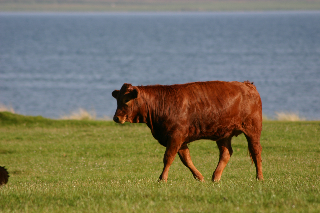

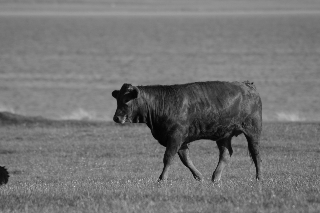

In [110]:
#@title Initial Settings

random_seed = 0#@param {type:"number", min:0}
seed(random_seed)

images_dir = "MSRC_ObjCategImageDatabase_v1"
images_paths = [join(images_dir, fn) for fn in listdir(images_dir) if "_GT" not in fn and fn.endswith(".bmp")]
shuffle(images_paths)
fpath = images_paths[0]
img = cv2.imread(fpath)
bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)
cv2_imshow(bw_img)

This function allows to print different images in a single row. All pictures can be displayes if they have the same height.

In [4]:
def show(images):
  cv2_imshow(np.concatenate(images, axis=1))

In this part there is the **mser** detector useful to extract from an image the detected keypoints.

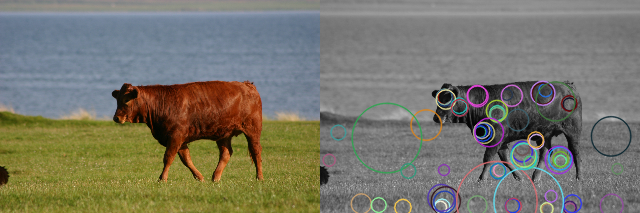

In [111]:
mser = cv2.MSER_create()

kp = mser.detect(img)

kp_img = cv2.drawKeypoints(bw_img, kp, 0, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show([img, kp_img])

Here the detected keypoints are computed using **sift** descriptor. The result of this phase is an encoding of image throw a list of descriptors. These are vectors that describes the behavior of keypoints inside the image.

In [112]:
sift = cv2.xfeatures2d.SIFT_create()

kp, des = sift.compute(img, kp) 

print(des)

[[  0.   2.   8. ...  27.  26.  22.]
 [  5.  11.  22. ...  41.  26.  40.]
 [ 46.  58.  69. ...   0.   0.   0.]
 ...
 [  4.   7.   9. ... 103.  23.  51.]
 [ 42.  19.  25. ...  38.  14.  13.]
 [  4.   6.  19. ...  55.  26.  67.]]


*ImgData* is a class useful to handle in a better way information of an image  (keypoints, descriptors, ...).

In [7]:
class ImgData:
  def __init__(self, path, kp, des):
    self.path = path
    self.kp = kp
    self.des = des
    self.feature_topics = np.array([]) 
    self.img_topics = np.array([]) 
    self.code = None
    self.histogram = None
    self.med = None
    self.topics_detected_img = None

The following function it's able to create a list of *ImgData* appling **mser** detector and **sift** descriptor to different images related to the passed list of paths. Before mser the loaded image is converted in black and white version.

In [114]:
def create_list_imgdata(paths):
  list_data = []
  for path in paths:
    img = cv2.imread(path)
    if img is not None and len(img) > 0:
      bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      kp = mser.detect(bw_img)
      kp, des = sift.compute(bw_img, kp)
      list_data.append(ImgData(path, kp, des))
  return list_data

This function is usedto split a dataset given from a list of image paths in two structured set that are **training** and **test** set.

In [115]:
def split_dataset(images_paths, n_ts_items):
  TR_set = create_list_imgdata(images_paths[:-n_ts_items])
  TS_set = create_list_imgdata(images_paths[-n_ts_items:])
  return TR_set, TS_set

#@title Image Importing Settings
total_dataset_size = 50#@param {type:"number", min: 0}
n_ts_items = 2#@param {type:"number", min: 0}

TR_set, TS_set = split_dataset(images_paths[:total_dataset_size], n_ts_items)

The function above is able to extract from the codebook the information related to a single imgdata and assigning them to it. Histogram of image features is one of this information.

In [96]:
def histogram_extraction(list_imgdata, codebook):
  for imgdata in list_imgdata:
    if imgdata.des is not None:
      normalized_des = vq.whiten(imgdata.des)
      code, med = vq.vq(normalized_des, codebook)
      histogram, bins = np.histogram(code, bins=range(codebook.shape[0] + 1))
      imgdata.histogram = list(enumerate(histogram))
      imgdata.code = code
      imgdata.med = med

The following is the function used to apply the kmeans algorithm to a training set to extract a codebook. This is used then to extract an histogram from each image that is a representation of it and is called Bag Of Features (BOF). An image is seen as an histogram that tracks the intensity of different features inside of it.

In [97]:
def apply_kmeans(TR_set, n_clusters):
  stack_des = reduce(lambda x, y: np.vstack((x, y)), 
                  map(lambda x: x.des, 
                      filter(lambda x: x.des is not None, TR_set))
                  )
  normalized_stack = vq.whiten(stack_des)
  codebook, med = vq.kmeans(normalized_stack, n_clusters)
  histogram_extraction(TR_set, codebook)
  return codebook, med

#@title K-Means Settings
n_clusters = 500#@param {type:"number", min: 1}
codebook, med = apply_kmeans(TR_set, n_clusters)

print(f"Mean Euclidean Distance: {med}")

Mean Euclidean Distance: 0.43947160243988037


Here are extracted BOF from test set and shown each histogram with the related image.

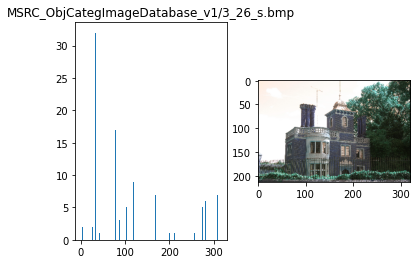

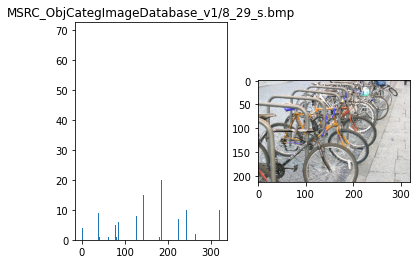

In [116]:
histogram_extraction(TS_set, codebook)

for i, imgdata in enumerate(TS_set):
  fig, axs = plt.subplots(1, 2)
  axs[0].set_title(imgdata.path)
  axs[0].hist(imgdata.code, codebook.shape[0])
  axs[1].imshow(cv2.imread(imgdata.path))
  plt.show()

*Topic* is a class built to have a representation of topic with some minimal features and a relationship with a list of image with this as main topic. The static method is used to create a list of topic an an automatic way.

In [99]:
class Topic:

  def __init__(self, id, text, color):
    self.id = id
    self.text = text
    self.color = color
    self.list_imgdata = []
  
  @staticmethod
  def create_list_topics(n_topics):
    return [Topic(i, f"Topic {i}", (randint(0, 255), randint(0, 255), randint(0, 255))) for i in range(n_topics)]

This function apply the **lda** algorithm to the test set after training it with a training set. To apply this before are setted two hyperparameters:
- n_topics: number of topics that lda use to relate images with topics and features with topics
- alpha: parameter that leaves between 0 and 1 that handle the mixing between topics. More it tends to zero more main topics tends to high and others low.

In [100]:
def apply_lda(alpha, n_topics, TR_set, TS_set):
  unique_histogram = [imgdata.histogram for imgdata in TR_set if imgdata.histogram is not None]
  lda = LdaModel(unique_histogram, alpha=alpha, num_topics=n_topics, minimum_probability=0)
  for imgdata in TS_set:
    img_topics, feature_topics, phi_values = lda.get_document_topics(imgdata.histogram, per_word_topics=True, minimum_probability=0) 
    imgdata.feature_topics = feature_topics
    imgdata.img_topics = img_topics

#@title LDA Settings
alpha = 0.1#@param {type:"slider", min:0.01, max:1, step:0.01}
n_topics =  15#@param {type:"slider", min:1, max:50, step:1}
topics = Topic.create_list_topics(n_topics)

apply_lda(alpha, n_topics, TR_set, TS_set)

The following function is able to create an image that shows detected topics coloring each detected keypoint. This is also capable to create a histogram of topic values assigned to the picture.

In [101]:
def topics_detection(imgdata, topics):
  selected_topics = []
  img = cv2.imread(imgdata.path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  for i_code, kp in zip(imgdata.code, imgdata.kp):
    ordered_topics = imgdata.feature_topics[i_code][1]
    if len(ordered_topics) > 0:
      topic = topics[ordered_topics[0]]
      size = int(kp.size/2)
      pos = (int(kp.pt[0]), int(kp.pt[1]))
      img = cv2.drawKeypoints(img, [kp], 0, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=topic.color)
      img = cv2.putText(img, str(topic.id), pos, cv2.FONT_HERSHEY_SIMPLEX, size/50, topic.color, 1, 1)
      selected_topics.append(topic.id)
  selected_topic = np.array(np.argmax(np.bincount(selected_topics)))
  return img, selected_topic
  
def imgdata_topics_detection(list_imgdata, topics):
  for imgdata in list_imgdata:
    topics_detected_img, topic_id = topics_detection(imgdata, topics)
    imgdata.topics_detected_img = topics_detected_img
    topics[topic_id].list_imgdata.append(imgdata)

imgdata_topics_detection(TS_set, topics)

Function that prints for each topic inside a list the related images and the histogram with the list of topic values assigned to each image.

Topic 2


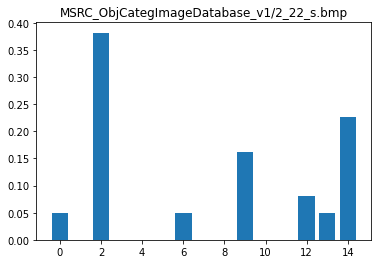

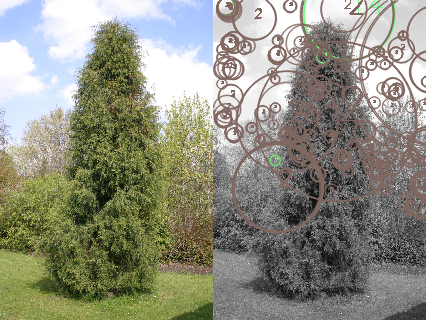

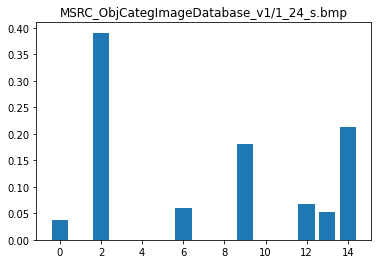

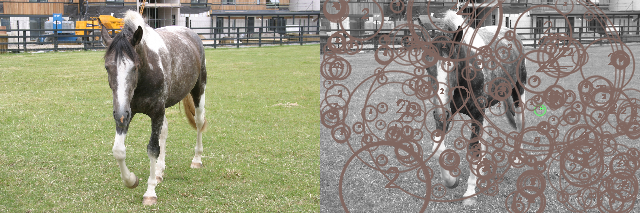

In [102]:
def show_topics_imgs(topics):
  for topic in topics:
    if len(topic.list_imgdata) > 0:
      print(topic.text)
      for imgdata in topic.list_imgdata:
        plt.title(imgdata.path)
        y = list(map(lambda x: x[1], imgdata.img_topics))
        plt.bar(range(len(imgdata.img_topics)), y, align='center')
        plt.show()
        show([cv2.imread(imgdata.path), imgdata.topics_detected_img])
  
show_topics_imgs(topics)

# Analysis

*Hyperparams* is a class built to create an object useful to store and use hyperparameters inside model selection phase.

In [103]:
class Hyperparams:
  
  def __init__(self, n_clusters, alpha, n_topics):
    self.n_clusters = n_clusters
    self.alpha = alpha
    self.n_topics = n_topics


The following function wrap all the passages of the process to detect features, create codebook, create BOF, apply lda and detect topics.

In [104]:
def model_selection(hyperparams, dataset):
  TR_set, TS_set = dataset
  codebook, med = apply_kmeans(TR_set, hyperparams.n_clusters)
  histogram_extraction(TS_set, codebook)
  topics = Topic.create_list_topics(hyperparams.n_topics)
  apply_lda(hyperparams.alpha, hyperparams.n_topics, TR_set, TS_set)
  imgdata_topics_detection(TS_set, topics)
  show_topics_imgs(topics)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:139: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Topic 0


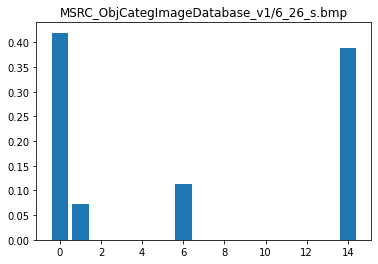

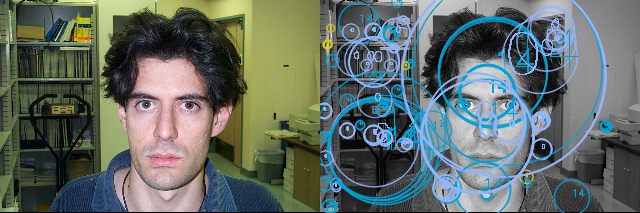

Topic 2


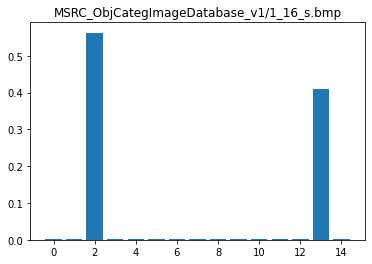

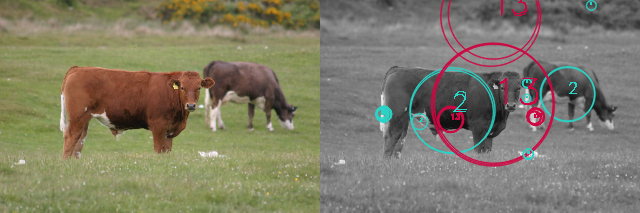

Topic 4


Topic 5


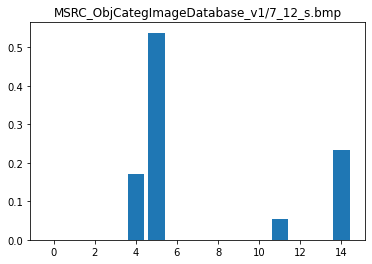

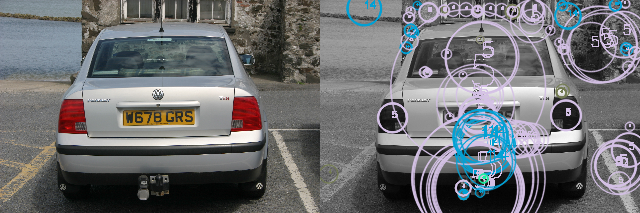

Topic 6


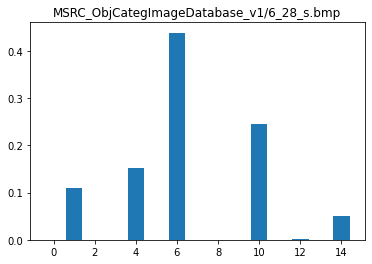

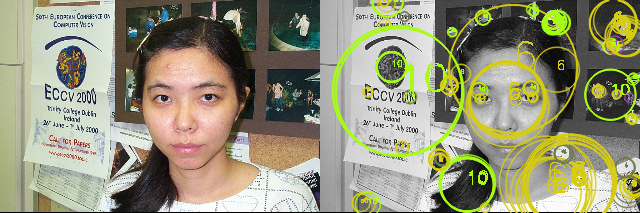

Topic 12


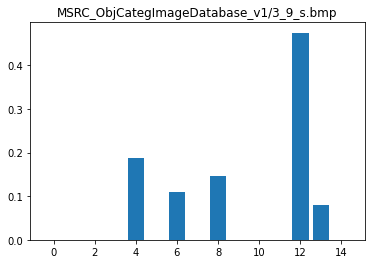

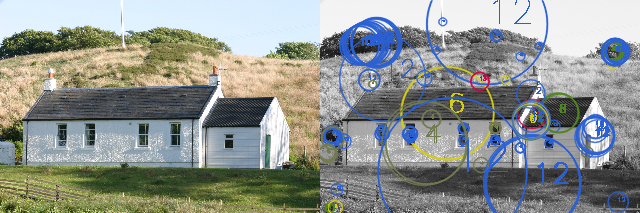

Topic 13


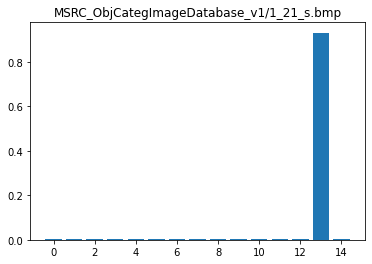

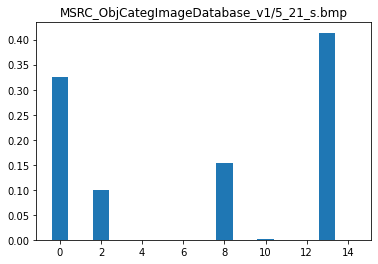

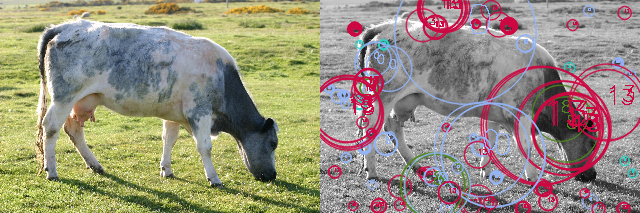

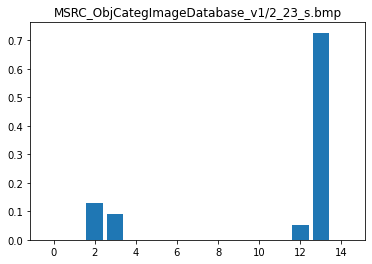

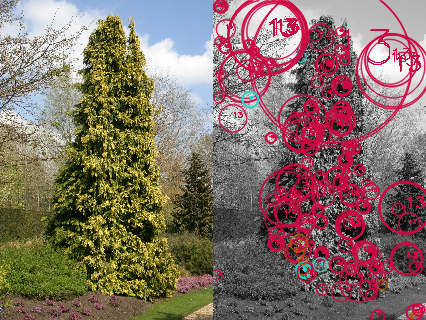

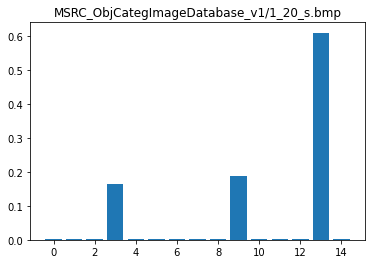

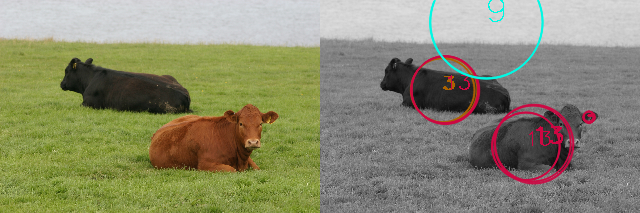

In [117]:
TR_set, TS_set = split_dataset(images_paths, 10)
hyperparams = Hyperparams(500, 0.1, 15)
model_selection(hyperparams, (TR_set, TS_set))